# Exploring the encoder outputs

In this script, we will read in the encoder outputs. They are saved as numpy objects and gzipped. Then we do a umap reduction on the tokens of interest.

In [69]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import gzip
import polars as pl
import sklearn.cluster as cluster
import hdbscan
from transformers import AutoTokenizer
import re
model_name = 'gena-lm-bert-base'
tokenizer = AutoTokenizer.from_pretrained(f'AIRI-Institute/{model_name}')
print("All libraries imported!")

All libraries imported!


# File reading

## 1. Encoder output matrix

In [3]:
job_id = "6531478"
chr_names = "all_chr"
f = gzip.GzipFile(f"../proc/{job_id}_{chr_names}_embed_dims.npy.gz", "r")
embed_dim = np.load(f)
embed_dim.shape

(77039, 512, 64)

## 2. The labels

In [44]:
with open(f"../proc/{job_id}_token_labels.txt") as file:
    labels = file.read()

# removing random chars inserted while saving the list
labels = labels.replace("[", "")
labels = labels.replace("]", "")
labels = labels.replace("\'", "")
labels = list(labels.split(","))

# removing whitespace before string
labels = [chr.strip() for chr in labels]
old_labels = labels

labels = [chr.replace("chr23", "chrX") for chr in labels]
labels = [chr.replace("chr24", "chrY") for chr in labels]

len(labels)
labels[-4800]

'chrX'

In [29]:
labels_idx = [None] * len(labels)
for idx, label in enumerate(labels):
    labels_idx[idx] = proc_labels[idx] + "_" + str(idx)

labels_idx[0:10]

['chr1_0',
 'chr1_1',
 'chr1_2',
 'chr1_3',
 'chr1_4',
 'chr1_5',
 'chr1_6',
 'chr1_7',
 'chr1_8',
 'chr1_9']

## 3. Input tokens

In [7]:
f = gzip.GzipFile(f"../proc/{job_id}_input_tokens_matrix.npy.gz", "r")
input_tokens = np.load(f)
input_tokens.shape

(77039, 512)

#  Token extraction

## CLS token

Taking the first token of each of the sequences in the batches, all the dimensions

In [12]:
cls_stack = np.zeros((embed_dim.shape[0], embed_dim.shape[2]))
for x in range(embed_dim.shape[0]):
    curr_stack = embed_dim[x:x+1, 0:1, :].flatten()
    cls_stack = np.vstack((cls_stack, curr_stack))

# removing the 0 rows
cls_stack = cls_stack[~np.all(cls_stack == 0, axis=1)]
cls_stack.shape

(77039, 64)

## CHR token

That is the second token of each sequence in the batches, all the dims

In [11]:
chr_stack = np.zeros((embed_dim.shape[0], embed_dim.shape[2]))
for x in range(embed_dim.shape[0]):
    curr_stack = embed_dim[x:x+1, 1:2, :].flatten()
    chr_stack = np.vstack((chr_stack, curr_stack))

# removing the 0 rows
chr_stack = chr_stack[~np.all(chr_stack == 0, axis=1)]
chr_stack.shape

(77039, 64)

# Umap reduction

## Color palette and other initialisation

In [ ]:
umap_red = umap.UMAP()

# defining the color scheme
"""
umap_palette = {"chr1": "salmon",
                "chr2": "brown",
                "chr3": "silver",
                "chr4": "peru",
                "chr5": "orange",
                "chr6": "goldenrod",
                "chr7": "gold",
                "chr8": "darkkhaki",
                "chr9": "olive",
                "chr10": "lawngreen",
                "chr11": "forestgreen",
                "chr12": "mediumspringgreen",
                "chr13": "darkturquoise",
                "chr14": "teal",
                "chr15": "aquamarine",
                "chr16": "deepskyblue",
                "chr17": "steelblue",
                "chr18": "navy",
                "chr19": "slateblue",
                "chr20": "darkorchid",
                "chr21": "plum",
                "chr22": "hotpink",
               }
"""

## cls token

In [52]:
umap_embed_cls = umap_red.fit_transform(cls_stack)
umap_embed_cls.shape

(77039, 2)

In [53]:
# making a df to use with seaborn
umap_df_cls = pl.from_numpy(umap_embed_cls, schema=["UMAP 1", "UMAP 2"])
umap_df_cls = umap_df_cls.with_columns(
    pl.Series("chr", labels),
    pl.Series("idx", labels_idx).map_elements(
        lambda x: int(x.split("_")[1])
    )
)
umap_df_cls

UMAP 1,UMAP 2,chr,idx
f32,f32,str,i64
-10.655241,-0.887091,"""chr1""",0
5.379274,-3.601365,"""chr1""",1
2.487651,-3.028118,"""chr1""",2
2.458991,-3.137859,"""chr1""",3
1.930516,-1.310769,"""chr1""",4
-5.168718,-8.78633,"""chr1""",5
6.106571,-3.905571,"""chr1""",6
4.724926,13.663056,"""chr1""",7
8.560005,-10.213018,"""chr1""",8


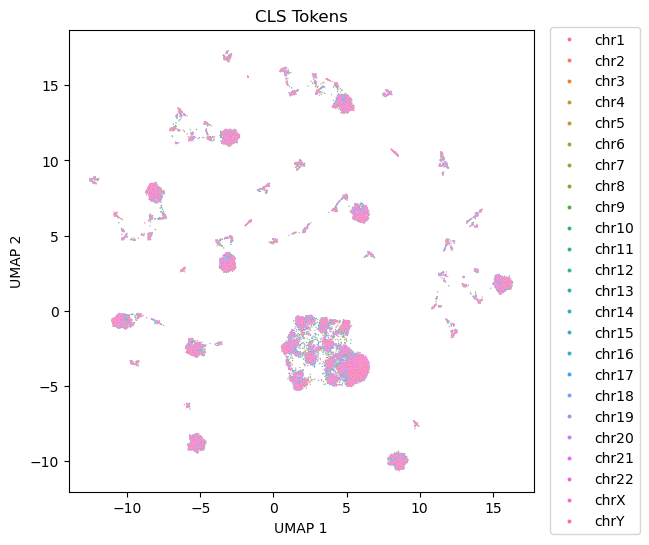

In [59]:
fig, ax = plt.subplots(1, figsize=(6, 6))

ax = sns.scatterplot(data=umap_df_cls, x="UMAP 1", y="UMAP 2", s=0.9, hue="chr")

plt.legend(markerscale=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1.02))
plt.title("CLS Tokens")
fig.savefig(f"../plots/{job_id}_{chr_names}_cls_umap.pdf", bbox_inches='tight')

### Exploring the clusters

#### cluster 1

In [120]:
# extracting the center big cluster
clst = umap_df_cls.filter(
    (pl.col("UMAP 1") > 0) & 
    (pl.col("UMAP 1") < 5) &
    (pl.col("UMAP 2") > -5) &
    (pl.col("UMAP 2") < 0)
)

seq_to_pick = list(clst['idx'])
print(seq_to_pick[0:10])
len(seq_to_pick)

clst1_seq = input_tokens[seq_to_pick, ]
print(len(clst1_seq))

[2, 3, 4, 9, 15, 22, 24, 28, 36, 40]
16329


#### cluster 2

In [126]:
# extracting the small bottom right cluster
clst_2 = umap_df_cls.filter(
    (pl.col("UMAP 1") > 5) & 
    (pl.col("UMAP 1") < 10) &
    (pl.col("UMAP 2") > -11) &
    (pl.col("UMAP 2") < -9)
)

seq_to_pick = list(clst_2['idx'])
print(seq_to_pick[0:10])
print(len(seq_to_pick))

clst2_seq = input_tokens[seq_to_pick, ]
print(len(clst2_seq))
print(clst2_seq.shape)

[8, 13, 33, 71, 165, 203, 222, 280, 315, 321]
2977
2977
(2977, 512)


### Checking distribution of token_ids

In [148]:
#concat1 = []
def concat_list(x):
    concat_list = concat1
    concat_list += x

    return concat_list

concat1 = clst1_seq.reshape(clst1_seq.shape[0] * clst1_seq.shape[1])
concat2 = clst2_seq.reshape(clst2_seq.shape[0] * clst2_seq.shape[1])

print(concat1[0:10])
print(len(concat1))

[    1 32001   236    45   405  8289  5209   109  1880   628]
8360448


In [149]:
concat1 = np.delete(concat1, np.where(concat1 == 1))
concat1 = np.delete(concat1, np.where(concat1 == 2))
concat1 = np.delete(concat1, np.where(concat1 == 3))
concat2 = np.delete(concat2, np.where(concat2 == 1))
concat2 = np.delete(concat2, np.where(concat2 == 2))
concat2 = np.delete(concat2, np.where(concat2 == 3))
#concat1.remove(1)
#concat1.remove(2)
#concat2.remove(1)
#concat2.remove(2)

print(concat1[0:10])

[32001   236    45   405  8289  5209   109  1880   628  2561]


In [150]:
uniq1, freq1 = np.unique(concat1, return_counts=True)
uniq2, freq2 = np.unique(concat2, return_counts=True)

In [176]:
concat1_df = pl.DataFrame([
    pl.Series("uniq", uniq1),
    pl.Series("freq", freq1),
    pl.Series("cluster", [1] * len(uniq1))
])
concat2_df = pl.DataFrame([
    pl.Series("uniq", uniq2),
    pl.Series("freq", freq2),
    pl.Series("cluster", [2] * len(uniq2))
])

concat_all = concat1_df.vstack(concat2_df)
concat_all.shape
concat_all.head()

uniq,freq,cluster
i64,i64,i64
7,2,1
8,4522,1
10,568,1
11,237,1
12,2714,1


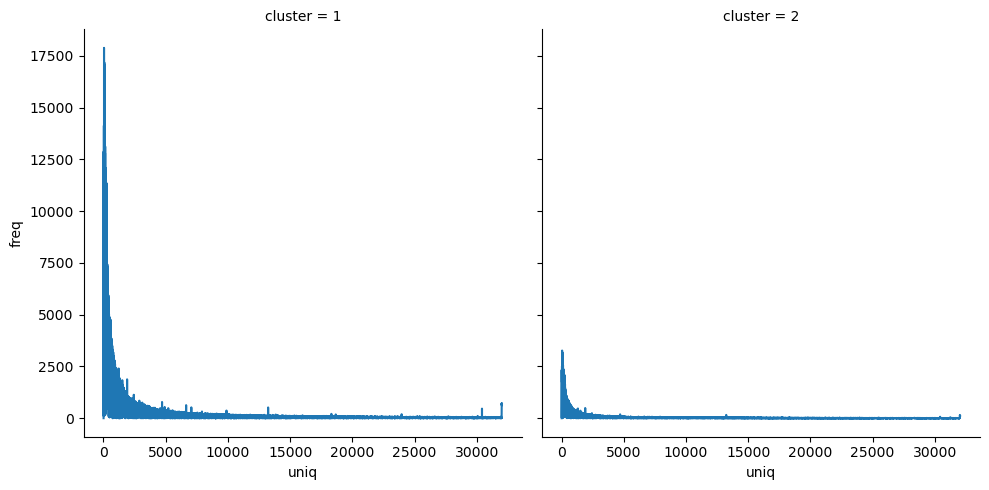

In [185]:
sns.relplot(data=concat_all, 
            x="uniq", 
            y="freq", 
            col="cluster", 
            kind="line"
)

plt.savefig(f"../plots/{job_id}_{chr_names}_token_usage_comp.pdf")

### Processing of the cluster sequence

In [114]:
clst_seq = input_tokens[seq_to_pick, ]
print(clst_seq)
len(clst_seq)

[[    1 32001 13496 ...   348 11290     2]
 [    1 32001  6459 ...  6620 25767     2]
 [    1 32001 26713 ...  5196   588     2]
 ...
 [    1 32024   157 ...  6087   390     2]
 [    1 32024  1110 ...  1072 22698     2]
 [    1 32024   477 ...   246   159     2]]


2977

In [115]:
sequence = list(map(tokenizer.decode, clst_seq))
len(sequence)

2977

### Decoding the tokens

In [116]:
# Removing cls and sep tokens
sequence = [re.sub(r"\[CLS\]|\[SEP\]", "", x) for x in sequence]
print(len(sequence))

2977


In [117]:
# concating the sequence in one big and writing to file
concat_seq = "".join(sequence)
print(type(concat_seq))
print(concat_seq[0:10])
print(len(concat_seq))

subset_seq = concat_seq[0:100_000]
print(len(subset_seq))



<class 'str'>
TGAGCGCACC
9276813
100000


In [118]:
# saving to file
with open(f"../proc/{job_id}_{chr_names}_clst2_sequence_subset.txt", "w") as file:
    file.write(subset_seq)

### Tokens length distribution

In [33]:
tokens_len_dist = []
def get_tokens_dist(x):
    return len(tokenizer.decode(x)) - 10
    
tokens_dist = list(map(get_tokens_dist, input_tokens))
len(tokens_dist)

77039

In [46]:
tokens_dist_df = pl.DataFrame(
    tokens_dist,
    schema=["bp_covered"]
).with_columns(
    pl.Series("seq_id", range(0, len(tokens_dist))),
    pl.Series("chr", labels)
)
tokens_dist_df.head()

bp_covered,seq_id,chr
i64,i64,str
3152,0,"""chr1"""
3142,1,"""chr1"""
3110,2,"""chr1"""
3146,3,"""chr1"""
3168,4,"""chr1"""


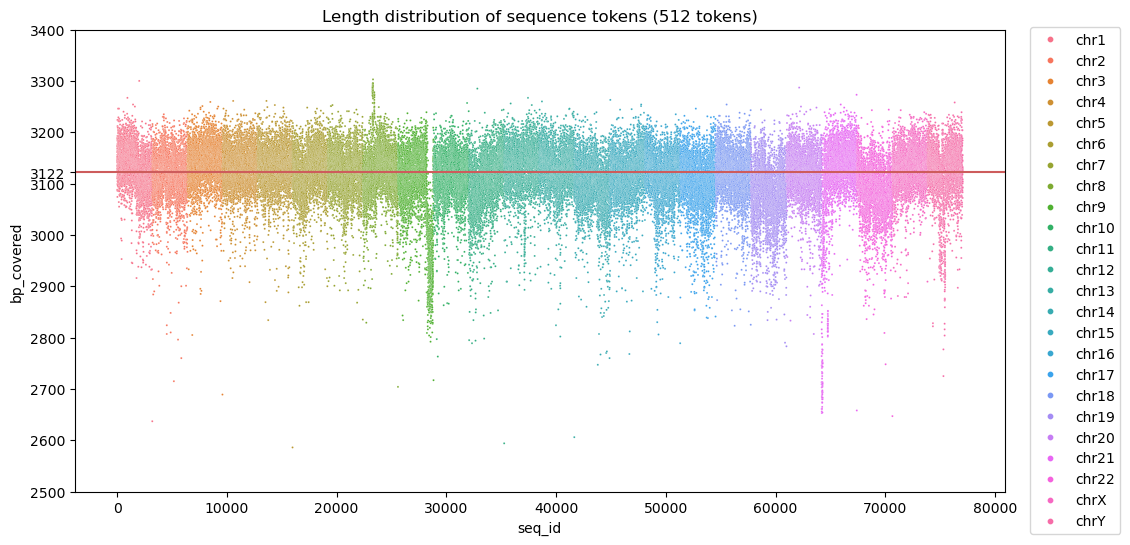

In [48]:
fig, ax = plt.subplots(1, figsize=(12,6))
sns.scatterplot(data=tokens_dist_df, x="seq_id", y="bp_covered", s=2, hue="chr")

# adding median line and ticks
plt.axhline(tokens_dist_df["bp_covered"].median(), color="indianred")
locs, _ = plt.yticks()
locs = np.insert(locs, 7, tokens_dist_df["bp_covered"].median())
plt.yticks(locs)

plt.legend(markerscale=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1.02))

plt.title("Length distribution of sequence tokens (512 tokens)")

fig.savefig(f"../plots/{job_id}_tokens_bp_covered.pdf", bbox_inches='tight')

## Chr token

In [14]:
umap_red = umap.UMAP()
umap_embed_chr = umap_red.fit_transform(chr_stack)
umap_embed_chr.shape

(77039, 2)

In [49]:
# making a df to use with seaborn
umap_df_chr = pl.from_numpy(umap_embed_chr, schema=["UMAP 1", "UMAP 2"])
umap_df_chr = umap_df_chr.with_columns(
    pl.Series("chr", labels), 
    pl.Series("idx", labels_idx).map_elements(lambda x: int(x.split("_")[1]))
)
umap_df_chr


UMAP 1,UMAP 2,chr,idx
f32,f32,str,i64
-9.848003,-2.450579,"""chr1""",0
-2.765462,-2.143781,"""chr1""",1
-2.531051,-2.337317,"""chr1""",2
-10.001284,-2.325247,"""chr1""",3
-0.99653,-7.431692,"""chr1""",4
-2.71365,-2.120039,"""chr1""",5
-9.441835,-2.078754,"""chr1""",6
-10.065483,-2.236826,"""chr1""",7
-10.028501,-2.277788,"""chr1""",8


### Seaborn approach

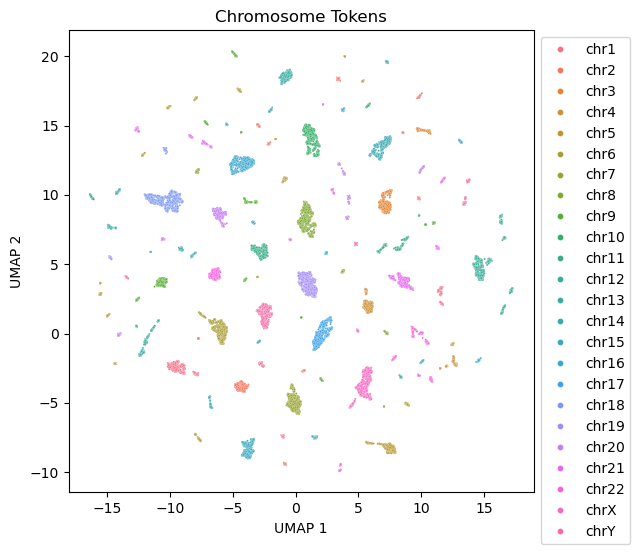

In [51]:
# chr tokens
fig, ax = plt.subplots(1, figsize=(6, 6))

ax = sns.scatterplot(data=umap_df_chr, x="UMAP 1", y="UMAP 2", s=2, hue="chr")

plt.legend(markerscale=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Chromosome Tokens")
fig.savefig(f"../plots/{job_id}_{chr_names}_chr_umap.pdf", bbox_inches='tight')

# Clustering Algos

## Kmeans

In [96]:
kmeans_labels = cluster.KMeans(n_clusters=22).fit_predict(chr_stack)
print(kmeans_labels)
kmeans_labels.shape

/home/sbanerj/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[20 20 20 ... 11 11 11]


(70582,)

In [97]:
# making a df to use with seaborn
umap_df_kmeans = pl.from_numpy(umap_embed_chr, schema=["UMAP 1", "UMAP 2"])
umap_df_kmeans = umap_df_kmeans.with_columns(pl.Series("kmeans_clusters", kmeans_labels))
umap_df_kmeans


UMAP 1,UMAP 2,kmeans_clusters
f32,f32,i32
-9.376163,-4.809048,20
-3.107883,11.999289,20
-10.456892,4.472487,20
-9.612835,4.527757,20
-10.84267,4.553201,20
-8.296642,-5.389375,20
-10.559668,4.630924,20
-9.366919,-4.809474,20
-10.752363,4.711307,20


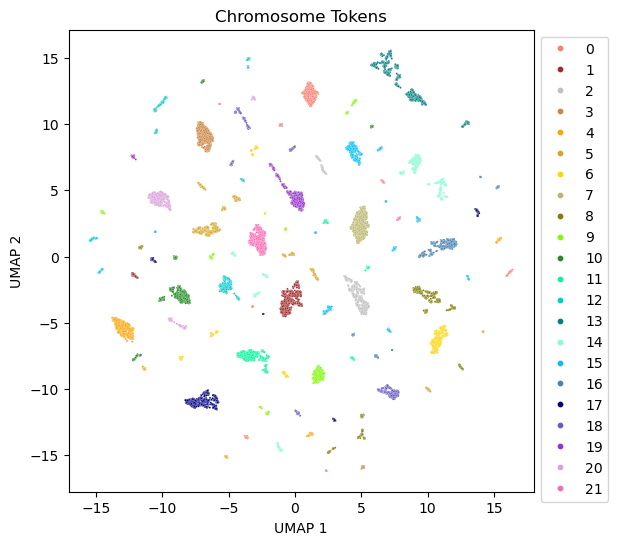

In [99]:
# chr tokens kmeans clustering
fig, ax = plt.subplots(1, figsize=(6, 6))

ax = sns.scatterplot(data=umap_df, x="UMAP 1", y="UMAP 2", s=2, hue="kmeans_clusters")

plt.legend(markerscale=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Chromosome Tokens")
fig.savefig(f"../plots/{chr_names}_chr_kmeans.pdf", bbox_inches='tight')

## HDBScan clustering

In [94]:
hdbscan_red = hdbscan.HDBSCAN()
hdbscan_red.fit(chr_stack)
print(hdbscan_red.labels_.max())
print(set(hdbscan_red.labels_))

24
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


In [92]:
# making a df to use with seaborn
umap_df_hdbs = pl.from_numpy(umap_embed_chr, schema=["UMAP 1", "UMAP 2"])
umap_df_hdbs = umap_df_hdbs.with_columns(
    pl.Series("hdbscan", hdbscan_red.labels_)
)
umap_df_hdbs["hdbscan"]

hdbscan
i64
10
10
10
10
10
10
10
10
10


Text(0.5, 1.0, 'Chromosome Tokens: HDBScan Clustering')

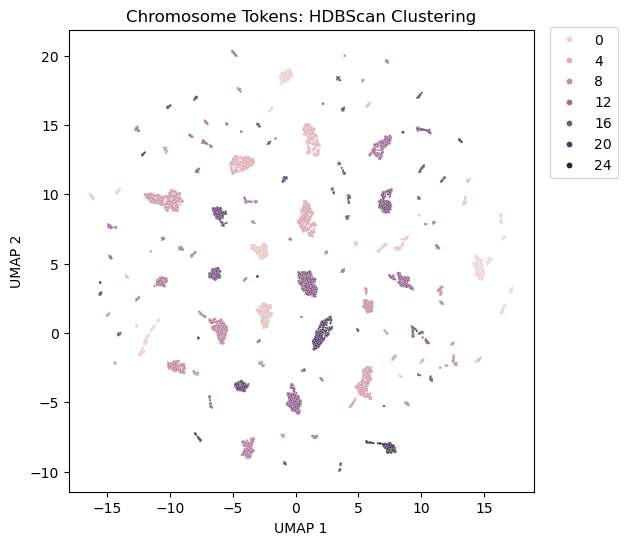

In [93]:
# chr tokens kmeans clustering
fig, ax = plt.subplots(1, figsize=(6, 6))

ax = sns.scatterplot(data=umap_df_hdbs, x="UMAP 1", y="UMAP 2", s=2, hue="hdbscan")

plt.legend(markerscale=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1.02))
plt.title("Chromosome Tokens: HDBScan Clustering")
#fig.savefig(f"../plots/{job_id}_{chr_names}_chr_hdbscan.pdf", bbox_inches='tight')

# Plt approach

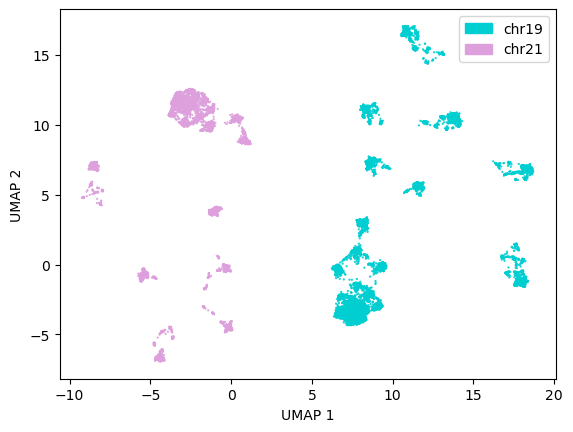

In [173]:
umap_embed = umap_red.fit_transform(chr_stack)
umap_embed.shape

classes= ["chr19", "chr21"]
label1 = mpatches.Patch(color='darkturquoise', label='chr19')
label2 = mpatches.Patch(color='plum', label='chr21')
#fig, ax = plt.subplots(1, figsize=(14, 10))
umap_plot = plt.scatter(*umap_embed.T, c=umap_colors, s=0.3)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(handles=[label1, label2])